# POCD Prediction from Structured EHR Data

In this notebook, we build and evaluate several machine learning models to predict Post-Operative Cognitive Dysfunction (POCD) from structured electronic health record (EHR) features.

The main steps are:
- Load and inspect the POCD dataset  
- Preprocess features (handle high-cardinality columns, encode categorical variables, scale numerical values)  
- Create stratified train/validation/test splits  
- Train a baseline Logistic Regression model - Proof of Concept (POC) 
- Tune Logistic Regression with cross-validation and study regularization paths  
- Train a tree-based model (Random Forest)  
- Train a Multi-Layer Perceptron (MLP) neural network  
- Train additional baseline models (GaussianNB, Linear SVM) 
- Compare models using PR-AUC and classification metrics

## 1. Data Loading and Initial Inspection

Loading the prepared POCD dataset from the Virtual Machine, inspecting its shape, and checking for missing values.  
The goal is to verify that the data is clean enough for modeling.

In [1]:
# Import libraries

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Pipelines
from sklearn.pipeline import Pipeline

In [2]:
DATA_PATH = "../data"
df = pd.read_csv(f"{DATA_PATH}/pocd_features_final.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (68550, 26)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,gender,anchor_age,anchor_year,anchor_year_group,dod,icd_code,POCD,transfer_count,icu_flag,icu_stay_hours
0,10002013,28185499,2167-12-14 11:17:00,2167-12-21 17:30:00,NaN,OBSERVATION ADMIT,P39X44,WALK-IN/SELF REFERRAL,REHAB,Medicaid,...,F,53,2156,2008 - 2010,NaN,['0Y6H0Z2'],1,9.0,0.0,175.668611
1,10002114,27793700,2162-02-17 22:32:00,2162-03-04 15:16:00,NaN,OBSERVATION ADMIT,P46834,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicaid,...,M,56,2162,2020 - 2022,2162-12-11,['0DJ08ZZ'],1,6.0,1.0,355.697778
2,10002348,22725460,2112-11-30 22:22:00,2112-12-10 17:56:00,NaN,OBSERVATION ADMIT,P25W49,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,...,F,77,2112,2017 - 2019,NaN,['00B70ZZ'],1,7.0,1.0,243.286944
3,10002428,28295257,2160-04-14 12:30:00,2160-04-18 16:00:00,NaN,OBSERVATION ADMIT,P086OF,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,F,80,2155,2011 - 2013,NaN,['0DJD8ZZ'],1,3.0,0.0,103.129444
4,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,NaN,URGENT,P336JM,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,...,M,81,2141,2014 - 2016,NaN,['027034Z'],1,3.0,1.0,165.414167


In [3]:
df.info()

# summary of missing values
missing_summary = (
    df.isna().sum().to_frame("missing_count")
    .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))
    .sort_values("missing_pct", ascending=False)
)
missing_summary.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68550 entries, 0 to 68549
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            68550 non-null  int64  
 1   hadm_id               68550 non-null  int64  
 2   admittime             68550 non-null  object 
 3   dischtime             68550 non-null  object 
 4   deathtime             2952 non-null   object 
 5   admission_type        68550 non-null  object 
 6   admit_provider_id     68548 non-null  object 
 7   admission_location    68550 non-null  object 
 8   discharge_location    62467 non-null  object 
 9   insurance             67715 non-null  object 
 10  language              68426 non-null  object 
 11  marital_status        65415 non-null  object 
 12  race                  68550 non-null  object 
 13  edregtime             38636 non-null  object 
 14  edouttime             38636 non-null  object 
 15  hospital_expire_fla

,missing_count,missing_pct
deathtime,65598,95.693654
dod,48122,70.199854
edregtime,29914,43.638220
edouttime,29914,43.638220
discharge_location,6083,8.873815
marital_status,3135,4.573304
insurance,835,1.218089
language,124,0.180890
admit_provider_id,2,0.002918
anchor_age,0,0.000000


In [4]:
import numpy as np
# Drop high-missing-value columns
df = df.drop(columns=["deathtime", "dod"])

# Handle emergency department times: create flag, then drop timestamps
df["ed_flag"] = np.where(df["edregtime"].notna(), 1, 0)
df = df.drop(columns=["edregtime", "edouttime"])

# Impute low-missing categorical variables
for col in ["discharge_location", "marital_status", "insurance", "language"]:
    df[col] = df[col].fillna(df[col].mode()[0])
    
df["admit_provider_id"] = df["admit_provider_id"].fillna(df["admit_provider_id"].mode()[0])

In [5]:
missing_summary = (
    df.isna().sum().to_frame("missing_count")
    .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))
    .sort_values("missing_pct", ascending=False)
)
missing_summary.head(20)

,missing_count,missing_pct
subject_id,0,0.0
hospital_expire_flag,0,0.0
icu_stay_hours,0,0.0
icu_flag,0,0.0
transfer_count,0,0.0
POCD,0,0.0
icd_code,0,0.0
anchor_year_group,0,0.0
anchor_year,0,0.0
anchor_age,0,0.0


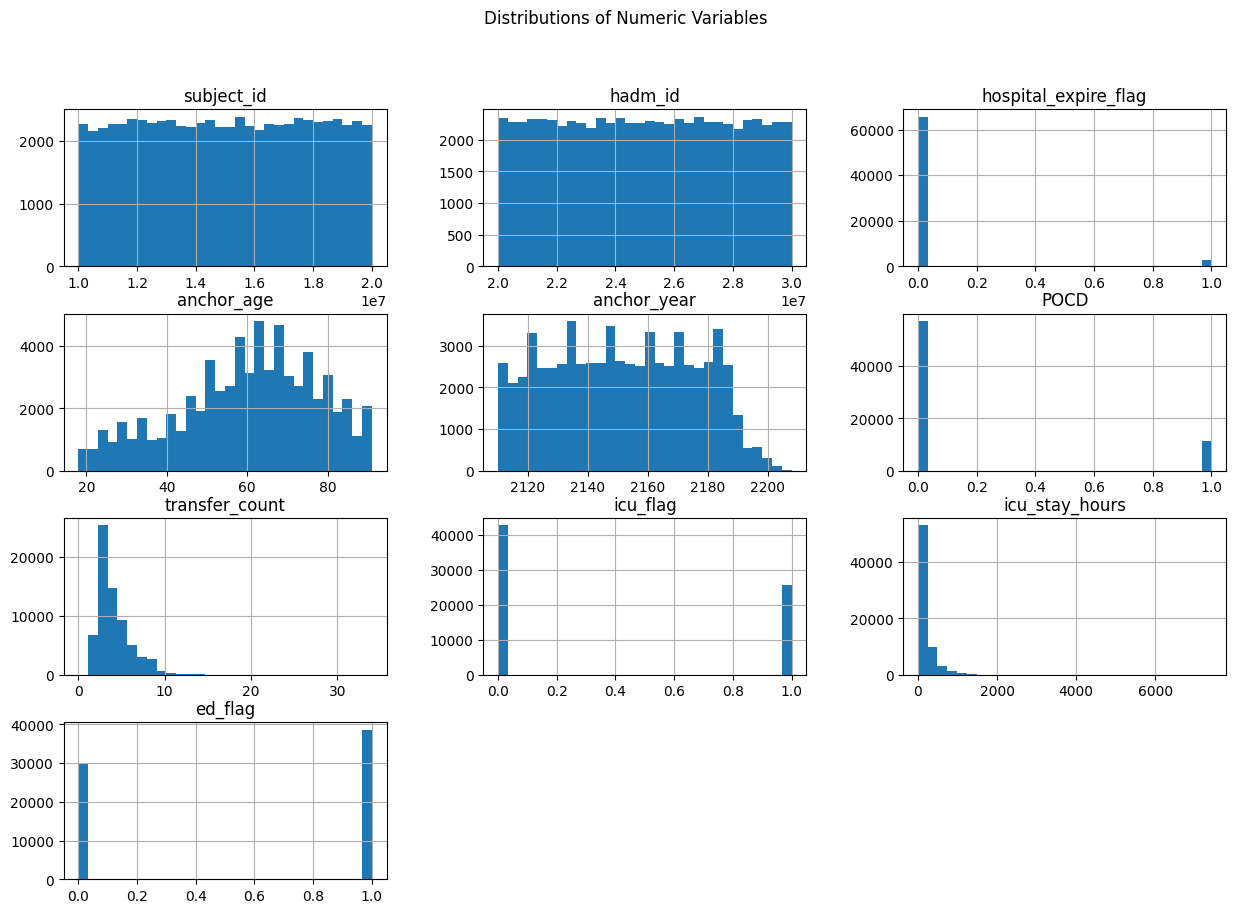

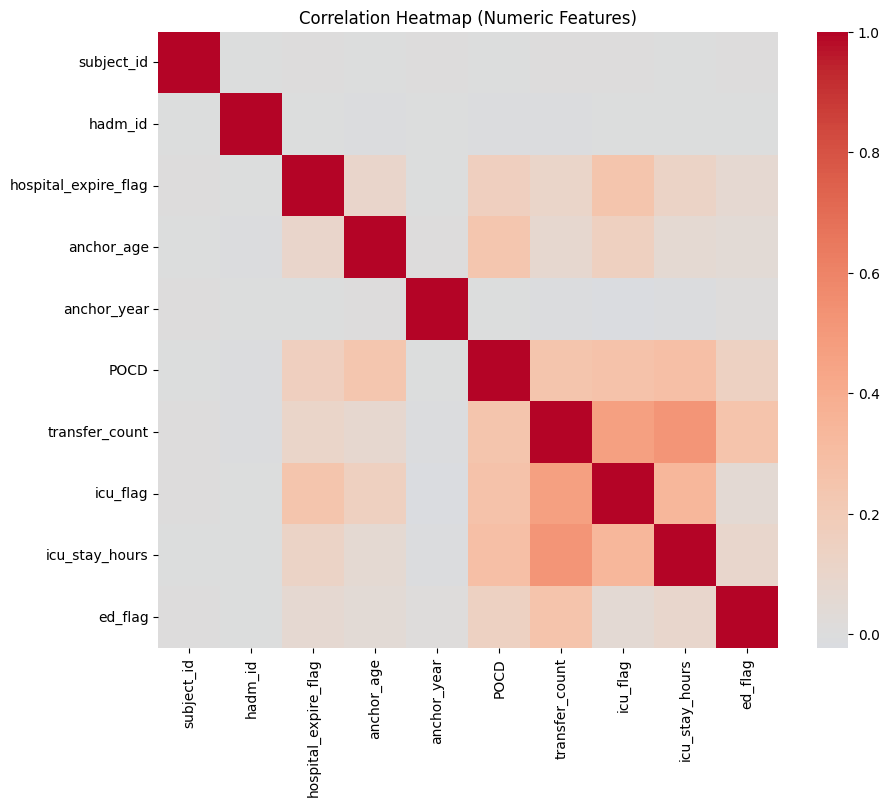

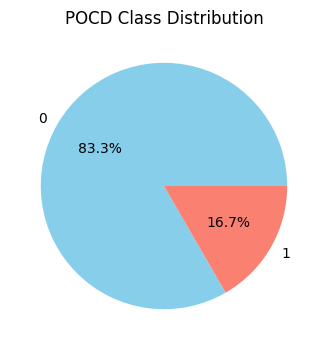

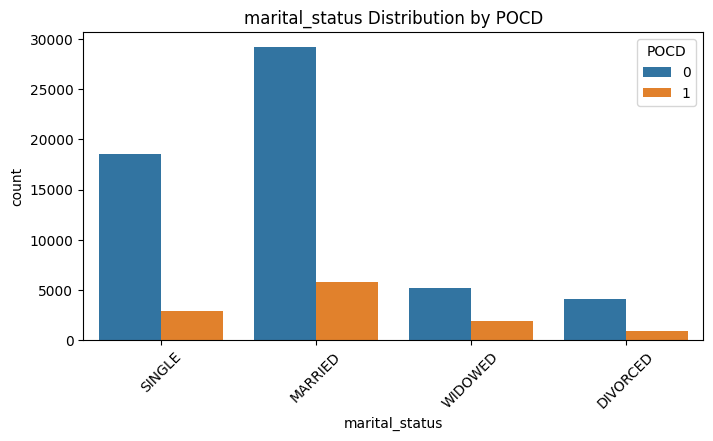

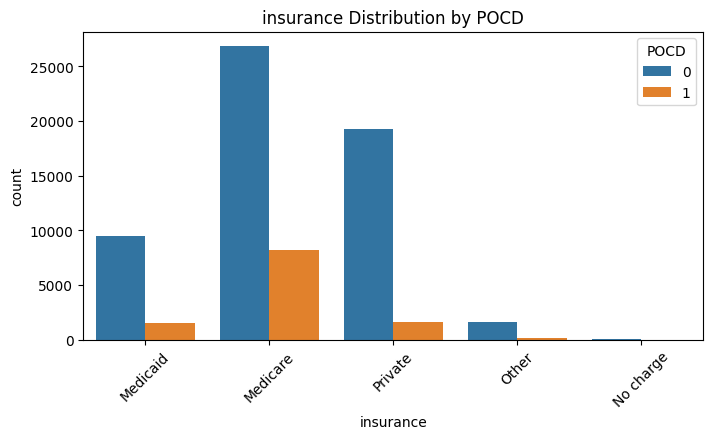

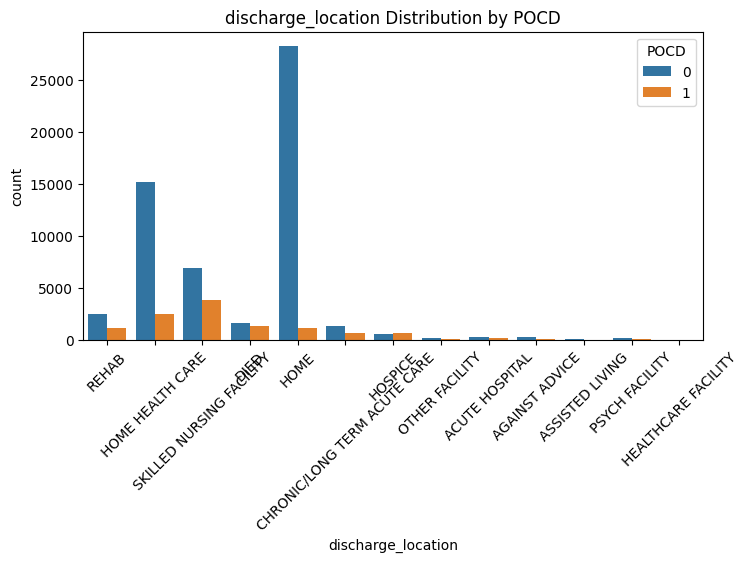

In [6]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

#print(num_cols)
#print(cat_cols)

# distribution of numeric features
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions of Numeric Variables")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Target distribution (POCD)
if "POCD" in df.columns:
    pocd_counts = df["POCD"].value_counts(normalize=True) * 100
    plt.figure(figsize=(4,4))
    plt.pie(pocd_counts, labels=pocd_counts.index, autopct="%.1f%%", colors=["skyblue","salmon"])
    plt.title("POCD Class Distribution")
    plt.show()

# categorical distributions
for col in ["marital_status", "insurance", "discharge_location"]:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(x=col, hue="POCD", data=df)
        plt.title(f"{col} Distribution by POCD")
        plt.xticks(rotation=45)
        plt.show()

## 2. Feature Preparation and Engineering

Prepare features and target:

- Set `POCD` as the binary target variable `y`  
- Drop the `POCD` column from the feature matrix `X`  
- Remove extremely high-cardinality identifiers (`language`, `admit_provider_id`, `icd_code`) that are not useful for a first baseline  
- Convert timestamp columns (`admittime`, `dischtime`) to numeric Unix time (seconds since epoch) so that models can use them as continuous features

In [7]:
# Define target
target_col = "POCD"
X = df.drop(columns=[target_col])
y = df[target_col]
print(X.shape, y.shape)

(68550, 22) (68550,)


In [8]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

#print("Numeric columns:", numeric_cols)
#print("Categorical columns:", categorical_cols)
cat_summary = X[categorical_cols].nunique().sort_values(ascending=False)
print(cat_summary.head(20))

dischtime             68237
admittime             67899
icd_code              27777
admit_provider_id      1503
race                     33
language                 25
discharge_location       13
admission_location       11
admission_type            9
insurance                 5
anchor_year_group         5
marital_status            4
gender                    2
dtype: int64


In [9]:
# Drop high-cardinality columns
drop_cols = ["language", "admit_provider_id", "icd_code"]
df = df.drop(columns=drop_cols)

# Convert admittime and dischtime to numeric (bigint)
for time_col in ["admittime", "dischtime"]:
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        df[time_col] = df[time_col].astype("int64") // 10**9  # convert to UNIX seconds

df.select_dtypes(exclude=["int64", "float64"]).nunique()

admission_type         9
admission_location    11
discharge_location    13
insurance              5
marital_status         4
race                  33
gender                 2
anchor_year_group      5
dtype: int64

## 3. Encoding Categorical Features and Scaling Numerical Features

Standardize feature representation:

- Identify categorical columns and one-hot encode them using `pd.get_dummies` with `drop_first=True` to avoid multicollinearity  
- Leave numeric columns as they are, then apply `StandardScaler` to all numeric features  
- Keep the final encoded feature matrix `X_encoded`, which will be used for all downstream models

This ensures that models like Logistic Regression, SVM, and MLP see features on comparable scales.

In [10]:
# Identify all categorical columns
categorical_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

X = df.drop(columns=["POCD"])
y = df["POCD"]                 

# One-hot encoding categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded.shape

(68550, 85)

In [11]:
numeric_cols = X_encoded.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

## 4. Train / Validation / Test Split

Splitting data into:

- 70% training  
- 15% validation  
- 15% test  

using stratified splits on `POCD` to preserve the class imbalance structure in each subset.

The train set is used for fitting and cross-validation, the validation set is used for intermediate model selection, and finally the train+validation set is combined for the final model fit before evaluating once on the held-out test set.

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## 5. Model Building

## Baseline Logistic Regression (No Tuning)

As a first baseline, training a Logistic Regression classifier with:

- `class_weight="balanced"` to account for POCD class imbalance   

Evaluating this baseline on the validation and test sets using:

- Classification report (precision, recall, F1)  
- Precision–Recall (PR) curve  
- PR-AUC, which is more informative than ROC-AUC in the imbalanced setting

In [13]:
model = LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="average_precision")

print("CV AUC scores:", np.round(cv_scores, 3))

CV AUC scores: [0.569 0.559 0.558 0.576 0.568]


              precision    recall  f1-score   support

           0       0.96      0.78      0.86      8569
           1       0.44      0.84      0.57      1713

    accuracy                           0.79     10282
   macro avg       0.70      0.81      0.72     10282
weighted avg       0.87      0.79      0.82     10282

Validation PR-AUC: 0.5708113084415398


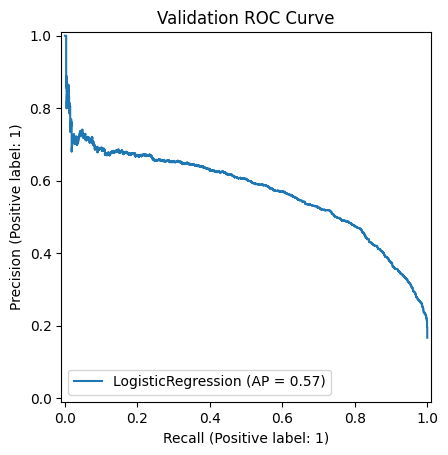

In [14]:
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("Validation PR-AUC:", average_precision_score(y_val, y_val_proba))

PrecisionRecallDisplay.from_estimator(model, X_val, y_val)
plt.title("Validation ROC Curve")
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      8569
           1       0.42      0.83      0.56      1714

    accuracy                           0.78     10283
   macro avg       0.69      0.80      0.71     10283
weighted avg       0.87      0.78      0.80     10283

Test PR-AUC: 0.5508035818817424


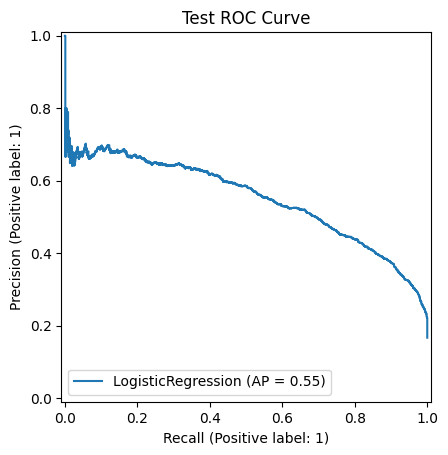

In [15]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_test_pred))
print("Test PR-AUC:", average_precision_score(y_test, y_test_proba))

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title("Test ROC Curve")
plt.show()

In [16]:
importance = pd.Series(model.coef_[0], index=X_encoded.columns).sort_values(key=abs, ascending=False)
top_features = importance.head(15).round(3)
top_features

anchor_year                                    -8.039
dischtime                                       4.109
admittime                                       4.101
anchor_year_group_2020 - 2022                   3.357
anchor_year_group_2017 - 2019                   3.077
anchor_year_group_2014 - 2016                   2.382
discharge_location_HOME                        -1.419
admission_type_EU OBSERVATION                  -1.067
admission_location_INFORMATION NOT AVAILABLE    1.032
anchor_year_group_2011 - 2013                   0.902
admission_type_OBSERVATION ADMIT                0.899
race_HISPANIC OR LATINO                        -0.898
admission_type_DIRECT EMER.                     0.824
admission_type_URGENT                           0.813
race_MULTIPLE RACE/ETHNICITY                   -0.756
dtype: float64

## Tuned Logistic Regression with Cross-Validation

Tuning the Logistic Regression hyperparameters using `GridSearchCV`:

- Penalty type (L1 vs L2)  
- Inverse regularization strength `C`  
- Compatible solver options  

Using stratified cross-validation and `average_precision` (PR-AUC) as the scoring metric.

After selecting the best hyperparameters:
- Refit the best Logistic Regression model on the combined train+validation set  
- Evaluate performance on the held-out test set  
- Plot the test Precision–Recall curve and report the final PR-AUC

In [17]:
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 5, 10],
    "solver": ["liblinear"],
    "class_weight": ["balanced"]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=200),
    param_grid=param_grid,
    scoring="average_precision",
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print("Best CV PR-AUC:", grid_search.best_score_.round(3))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV PR-AUC: 0.567


In [18]:
# Combine train + val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# fit trained best model on full Train+Val set
best_model = grid_search.best_estimator_
best_model.fit(X_trainval, y_trainval)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,200
,multi_class,'deprecated'


              precision    recall  f1-score   support

           0       0.96      0.78      0.86      8569
           1       0.43      0.83      0.56      1714

    accuracy                           0.78     10283
   macro avg       0.69      0.80      0.71     10283
weighted avg       0.87      0.78      0.81     10283

Final Test PR-AUC: 0.5534022384471153


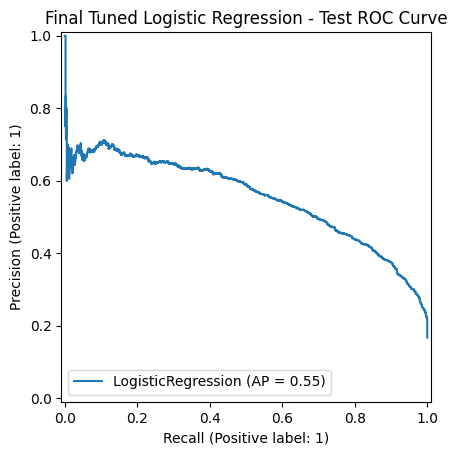

In [19]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_test_pred))
print("Final Test PR-AUC:", average_precision_score(y_test, y_test_proba))

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Final Tuned Logistic Regression - Test ROC Curve")
plt.show()

## Logistic Regression Feature Importance (Coefficients)

To understand which features drive the POCD predictions for the tuned Logistic Regression model:

- Extract the learned coefficients for the positive class  
- Sort features by coefficient magnitude  
- Plot the top positive and negative coefficients as a bar chart


Top 15 Predictors of POCD (Tuned Model):
 anchor_year                                    -6.219
dischtime                                       3.180
admittime                                       3.177
anchor_year_group_2020 - 2022                   2.641
anchor_year_group_2017 - 2019                   2.436
anchor_year_group_2014 - 2016                   1.900
discharge_location_HOME                        -1.371
admission_type_EU OBSERVATION                  -1.172
admission_location_PROCEDURE SITE              -0.716
discharge_location_HOME HEALTH CARE            -0.695
race_HISPANIC OR LATINO                        -0.648
admission_location_INFORMATION NOT AVAILABLE    0.632
anchor_year_group_2011 - 2013                   0.631
admission_location_CLINIC REFERRAL             -0.510
anchor_age                                      0.509
dtype: float64


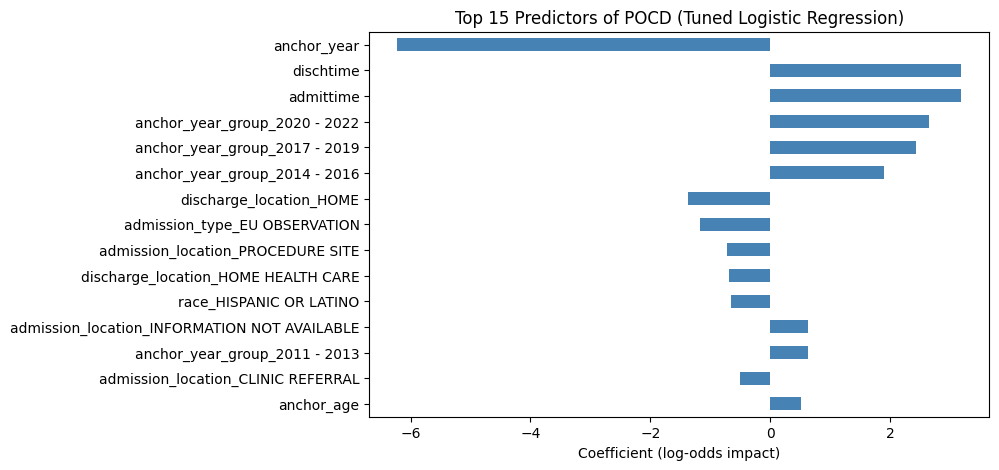

In [19]:
importance = pd.Series(best_model.coef_[0], index=X_encoded.columns).sort_values(key=abs, ascending=False)
top_features = importance.head(15).round(3)
print("\nTop 15 Predictors of POCD (Tuned Model):\n", top_features)

plt.figure(figsize=(8,5))
top_features[::-1].plot(kind="barh", color="steelblue")
plt.title("Top 15 Predictors of POCD (Tuned Logistic Regression)")
plt.xlabel("Coefficient (log-odds impact)")
plt.show()

## Logistic Regression Regularization Path

How model performance changes with different levels of regularization.

This helps visualize the bias–variance trade-off and shows how sensitive Logistic Regression is to the choice of regularization strength on this dataset.

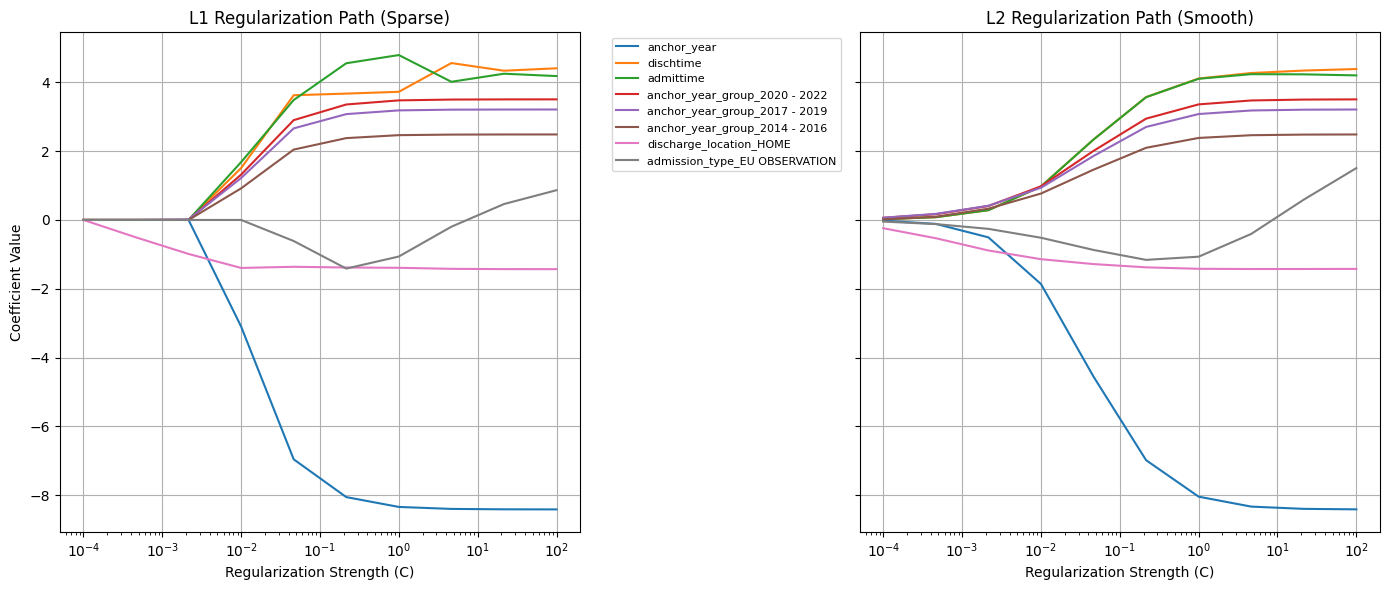

In [20]:
C_values = np.logspace(-4, 2, 10)
feature_names = X_encoded.columns

coef_path_l1, coef_path_l2 = [], []
for C in C_values:
    m_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=200, class_weight="balanced", C=C)
    m_l2 = LogisticRegression(penalty="l2", solver="liblinear", max_iter=200, class_weight="balanced", C=C)
    m_l1.fit(X_train, y_train)
    m_l2.fit(X_train, y_train)
    coef_path_l1.append(m_l1.coef_[0])
    coef_path_l2.append(m_l2.coef_[0])

coef_path_l1, coef_path_l2 = np.array(coef_path_l1), np.array(coef_path_l2)
top_feats = importance.abs().sort_values(ascending=False).head(8).index
feat_idx = [list(feature_names).index(f) for f in top_feats if f in feature_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# L1
for i in feat_idx:
    axes[0].plot(C_values, coef_path_l1[:, i], label=feature_names[i])
axes[0].set_xscale("log")
axes[0].set_title("L1 Regularization Path (Sparse)")
axes[0].set_xlabel("Regularization Strength (C)")
axes[0].set_ylabel("Coefficient Value")
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

# L2
for i in feat_idx:
    axes[1].plot(C_values, coef_path_l2[:, i], label=feature_names[i])
axes[1].set_xscale("log")
axes[1].set_title("L2 Regularization Path (Smooth)")
axes[1].set_xlabel("Regularization Strength (C)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Gaussian Naive Bayes Baseline

Fitting 5 folds for each of 3 candidates, totalling 15 fits
GaussianNB Best Params: {'var_smoothing': 1e-07}
GaussianNB Best CV PR-AUC: 0.395

GaussianNB Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.54      0.69      8569
           1       0.28      0.89      0.42      1714

    accuracy                           0.60     10283
   macro avg       0.62      0.71      0.56     10283
weighted avg       0.85      0.60      0.65     10283

GaussianNB Test PR-AUC: 0.397


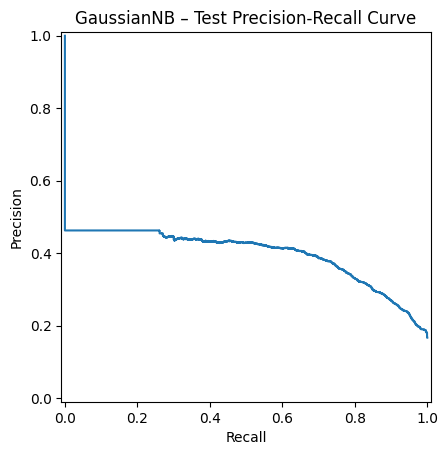

In [22]:
gnb = GaussianNB()
param_grid_gnb = {
    "var_smoothing": [1e-9, 1e-8, 1e-7]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnb_search = GridSearchCV(
    gnb,
    param_grid_gnb,
    scoring="average_precision",
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

gnb_search.fit(X_train, y_train)
print("GaussianNB Best Params:", gnb_search.best_params_)
print("GaussianNB Best CV PR-AUC:", round(gnb_search.best_score_, 3))

# refit on Train+Val
best_gnb = gnb_search.best_estimator_
best_gnb.fit(X_trainval, y_trainval)

# test evaluation
y_test_pred = best_gnb.predict(X_test)
y_test_proba = best_gnb.predict_proba(X_test)[:, 1]

print("\nGaussianNB Test Classification Report:\n",
      classification_report(y_test, y_test_pred))
print("GaussianNB Test PR-AUC:",
      round(average_precision_score(y_test, y_test_proba), 3))

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("GaussianNB – Test Precision-Recall Curve")
plt.show()

## Random Forest Classifier

Train a Random Forest classifier to capture non-linear interactions between features.

Key points:
- Use `class_weight="balanced"` to handle class imbalance  
- Tune a small grid of hyperparameters (`n_estimators`, `max_depth`, `min_samples_split`) with cross-validation and `average_precision` scoring  
- Refit the best Random Forest on train+validation data  
- Evaluate on the test set with PR-AUC and a Precision–Recall curve

Random Forest often provides a strong tree-based baseline for structured EHR data.

In [31]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    scoring="average_precision",  
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV PR-AUC:", grid_search.best_score_.round(3))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best CV PR-AUC: 0.556


In [32]:
# Refit best model
rf_best = RandomForestClassifier(
    class_weight="balanced",
    max_depth=20,
    min_samples_split=5,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_trainval, y_trainval)

,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      8569
           1       0.55      0.59      0.57      1714

    accuracy                           0.85     10283
   macro avg       0.73      0.75      0.74     10283
weighted avg       0.86      0.85      0.85     10283

Test PR-AUC: 0.559


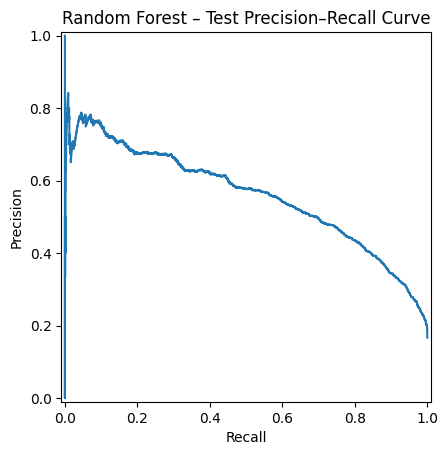

In [34]:
y_test_pred = rf_best.predict(X_test)
y_test_proba = rf_best.predict_proba(X_test)[:, 1]

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test PR-AUC:", round(average_precision_score(y_test, y_test_proba), 3))

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Random Forest – Test Precision–Recall Curve")
plt.show()

## Random Forest Depth Regularization Study

To understand the effect of model complexity, varying the `max_depth` of the Random Forest and:

- Train a model for each depth value using cross-validation  
- Record the PR-AUC for each depth  

Plot PR-AUC vs `max_depth` to observe how deeper trees affect overfitting and generalization performance on this dataset.

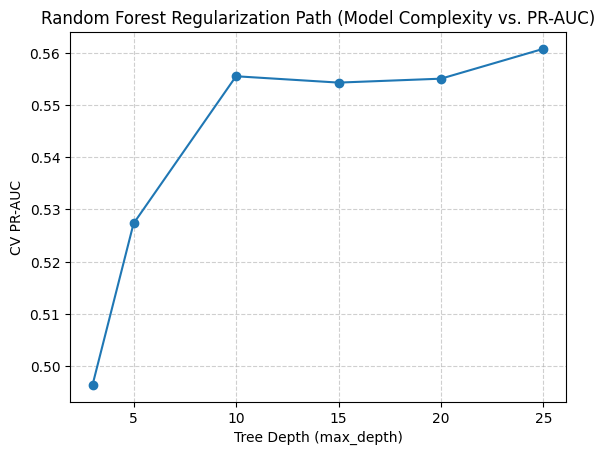

In [35]:
depths = [3, 5, 10, 15, 20, None]
scores = []

for d in depths:
    rf = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        max_depth=d
    )
    score = cross_val_score(rf, X_trainval, y_trainval, cv=5, scoring="average_precision").mean()
    scores.append(score)

plt.plot([d if d else 25 for d in depths], scores, marker='o')
plt.xlabel("Tree Depth (max_depth)")
plt.ylabel("CV PR-AUC")
plt.title("Random Forest Regularization Path (Model Complexity vs. PR-AUC)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Multi-Layer Perceptron (MLP) Classifier

Train a neural-network-based classifier using `MLPClassifier` inside a `Pipeline` with `StandardScaler`.

- Define a small grid over hidden layer sizes, activation functions, and regularization (`alpha`)  
- Use `GridSearchCV` with `average_precision` as the scoring metric  
- Select the best MLP configuration and refit it on the train+validation set  
- Evaluate on the test set with a classification report, PR-AUC, and a Precision–Recall curve

In [22]:
# Pipeline for scaling + MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=200, random_state=42, early_stopping=True, n_iter_no_change=8))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(100,), (50,)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [0.001, 0.01, 0.1],            
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with PR-AUC scoring
grid_search = GridSearchCV(
    mlp_pipe,
    param_grid,
    scoring="average_precision",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV PR-AUC:", round(grid_search.best_score_, 3))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (50,)}
Best CV PR-AUC: 0.564


In [23]:
best_mlp = grid_search.best_estimator_
best_mlp.fit(X_trainval, y_trainval)

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(50,)"
,activation,'relu'
,solver,'adam'
,alpha,0.1



Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      8569
           1       0.61      0.44      0.51      1714

    accuracy                           0.86     10283
   macro avg       0.75      0.69      0.72     10283
weighted avg       0.85      0.86      0.85     10283

Test PR-AUC: 0.555


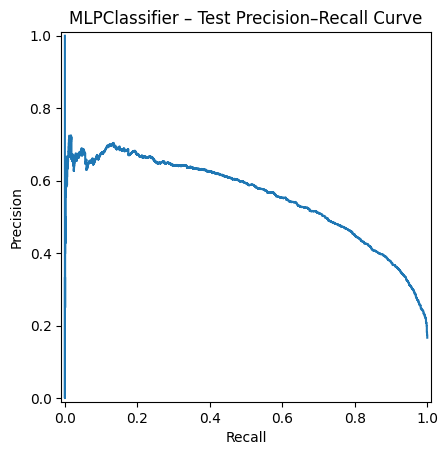

In [25]:
y_test_pred = best_mlp.predict(X_test)
y_test_proba = best_mlp.predict_proba(X_test)[:, 1]

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test PR-AUC:", round(average_precision_score(y_test, y_test_proba), 3))

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("MLPClassifier – Test Precision–Recall Curve")
plt.show()

In [ ]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),     # ensure all features are on similar scale
    ("svm", SVC(
        kernel="linear",
        probability=False,            # turning this off makes training much faster
        class_weight="balanced",      # helps with imbalanced POCD classes
        random_state=42
    )),
])

# Only tuning C (how strict the margin is). Keeping this grid small for speed.
param_grid_svm = {
    "svm__C": [0.1, 1, 10]
}

cv_svm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm_search = GridSearchCV(
    svm_pipe,
    param_grid_svm,
    scoring="average_precision",
    cv=cv_svm,
    verbose=1,
    n_jobs=-1
)

# Train only on the training portion
svm_search.fit(X_train, y_train)

print("Best Linear SVM params:", svm_search.best_params_)
print("CV PR-AUC:", round(svm_search.best_score_, 3))

# Fit best model on train + validation
best_svm = svm_search.best_estimator_
best_svm.fit(X_trainval, y_trainval)

# Predictions on the test set
y_pred = best_svm.predict(X_test)

# Since we disabled probabilities, we use the raw SVM decision scores
scores = best_svm.decision_function(X_test)

print("\nTest Classification Report:\n",
      classification_report(y_test, y_pred))
print("Test PR-AUC:",
      round(average_precision_score(y_test, scores), 3))

# PR curve
precision, recall, _ = precision_recall_curve(y_test, scores)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Linear SVM – Test Precision-Recall Curve")
plt.show()


Fitting 3 folds for each of 3 candidates, totalling 9 fits
